In [1]:
import numpy as np
import pandas as pd
import time


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('customer_data.csv')
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,160
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,121
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,130


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [4]:
df['CityTier'] = df['CityTier'].astype('category')
df['MaritalStatus'] = df['MaritalStatus'].astype('category')
df['Gender'] = df['Gender'].astype('category')

In [5]:
df.shape

(5630, 20)

In [6]:
# Select only numerical columns
df_num = df.select_dtypes(include=[int, float])
df_num = df_num.drop(columns=df_num.columns[:2])
df_num.shape

(5630, 12)

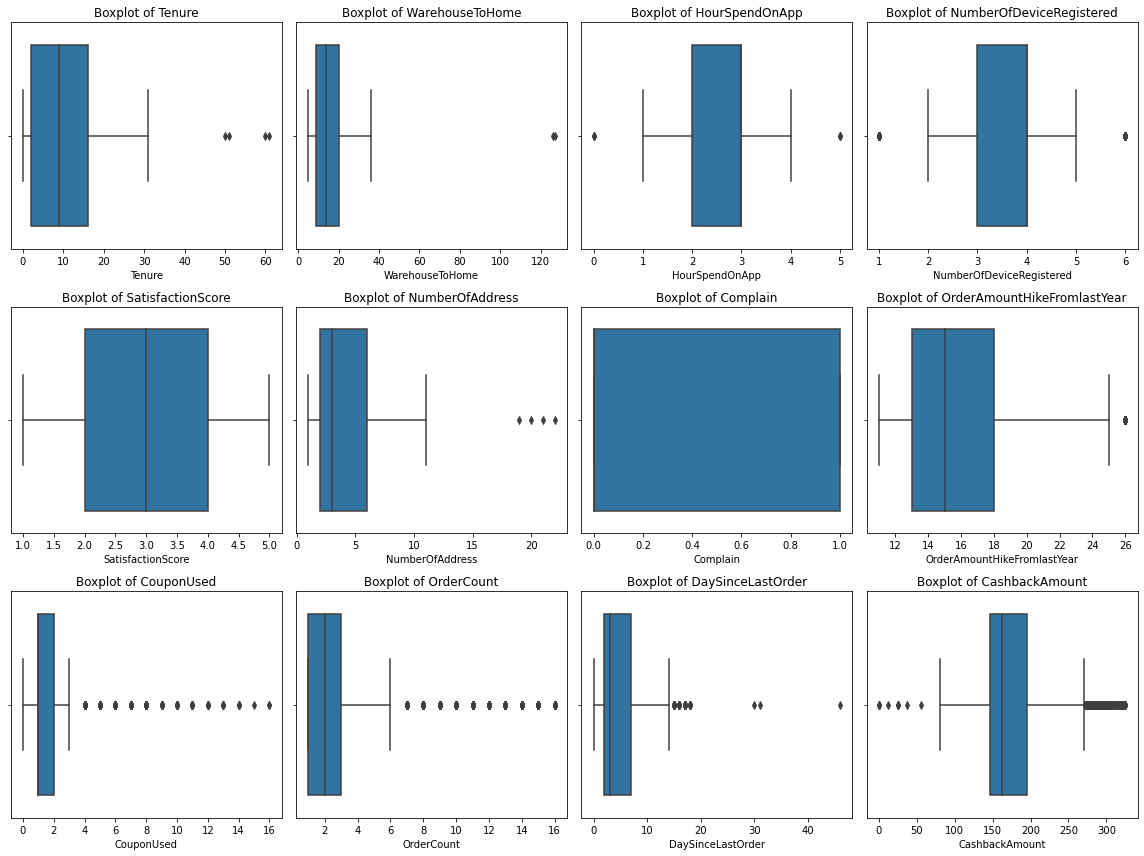

In [7]:
# Set up subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Loop through numerical columns and create boxplots
for i, column in enumerate(df_num.columns):
    sns.boxplot(x=df_num[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [8]:
# Function to replace outliers with median
def replace_outliers_with_median(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
# Replacing outliers with the median
    column = np.where((column < lower_bound) | (column > upper_bound), column.median(), column)
    return column

# Applying the function to each numerical column
numerical_columns = df.select_dtypes(include=[np.number]).columns
columns_to_exclude = ['CustomerID', 'Churn']
numerical_columns = [col for col in numerical_columns if col not in columns_to_exclude]
df[numerical_columns] = df[numerical_columns].apply(replace_outliers_with_median)

In [9]:
df.describe()

,CustomerID,Churn,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5630.000000,5630.000000,5366.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,52815.500000,0.168384,10.155237,15.598067,2.932093,3.756661,3.066785,4.201599,0.284902,15.640261,1.168776,2.022152,4.377607,167.041563
std,1625.385339,0.374240,8.466211,8.259223,0.716935,0.771520,1.380194,2.546850,0.451408,3.585530,0.803389,1.121577,3.351426,33.684180
min,50001.000000,0.000000,0.000000,5.000000,1.000000,2.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,81.000000
25%,51408.250000,0.000000,2.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,146.000000
50%,52815.500000,0.000000,9.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.000000
75%,54222.750000,0.000000,16.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,2.000000,7.000000,182.000000
max,55630.000000,1.000000,31.000000,36.000000,4.000000,5.000000,5.000000,11.000000,1.000000,25.000000,3.000000,6.000000,14.000000,271.000000


In [10]:
df.isna().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [11]:
# Replace NaN values with mean
df.fillna(df.mean(), inplace=True)

In [12]:
#Distribution of churn variable
classes=df['Churn'].value_counts()
not_churned=classes[0]/df['Churn'].count()*100
churned=classes[1]/df['Churn'].count()*100
print('churned =' ,churned)
print('not_churned =' ,not_churned)

churned = 16.838365896980463
not_churned = 83.16163410301954


<AxesSubplot:xlabel='Churn', ylabel='count'>

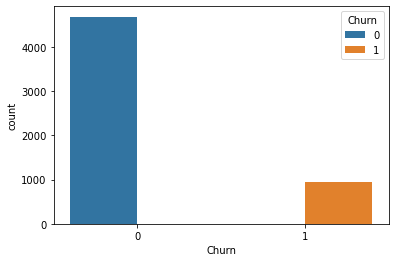

In [13]:
sns.countplot(x=df.Churn, hue=df.Churn)

In [14]:
# Churn by login device
churn_by_device = df.groupby(['PreferredLoginDevice', 'Churn']).agg({'CustomerID':'nunique'}).reset_index()
churn_by_device['Percentage of Customers'] = churn_by_device.groupby('PreferredLoginDevice')['CustomerID'].transform(lambda x: x / x.sum() * 100)
churn_by_device.columns = ['Login_Device', 'Churn', 'No of customers', 'Percentage']
churn_by_device

,Login_Device,Churn,No of customers,Percentage
0,Computer,0,1310,80.171359
1,Computer,1,324,19.828641
2,Mobile Phone,0,2417,87.414105
3,Mobile Phone,1,348,12.585895
4,Phone,0,955,77.579204
5,Phone,1,276,22.420796


In [15]:
# Churn by complain
churn_by_device = df.groupby(['Complain', 'Churn']).agg({'CustomerID':'nunique'}).reset_index()
churn_by_device['Percentage of Customers'] = churn_by_device.groupby('Complain')['CustomerID'].transform(lambda x: x / x.sum() * 100)
churn_by_device.columns = ['Complain', 'Churn', 'No of customers', 'Percentage']
churn_by_device

,Complain,Churn,No of customers,Percentage
0,0.0,0,3586,89.071038
1,0.0,1,440,10.928962
2,1.0,0,1096,68.329177
3,1.0,1,508,31.670823


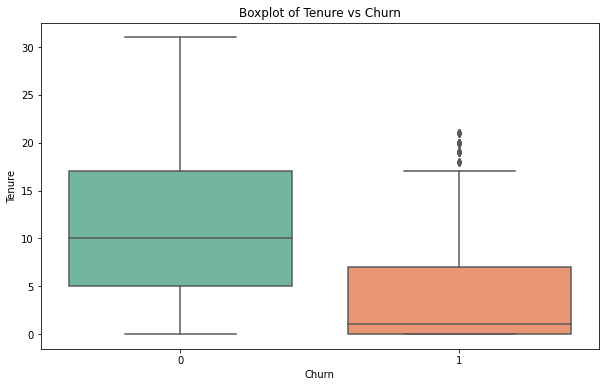

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Tenure', data=df, palette='Set2')
plt.title('Boxplot of Tenure vs Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

###### A customer with higher tenure is less likely to churn 

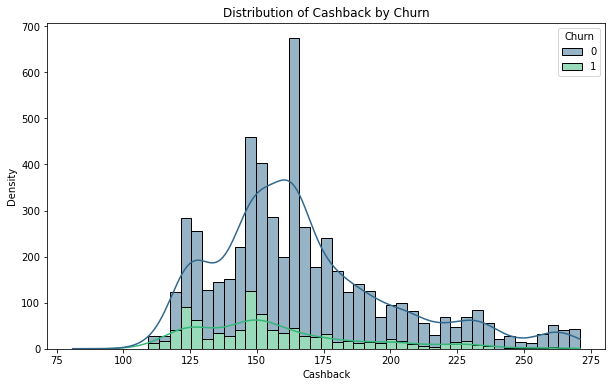

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x='CashbackAmount', hue='Churn', multiple='stack', kde=True, palette='viridis')
plt.title('Distribution of Cashback by Churn')
plt.xlabel('Cashback')
plt.ylabel('Density')
plt.show()

###### From the above graph, it is quite clear that if a customer receives regular cashbacks, he/she is likely to churn.

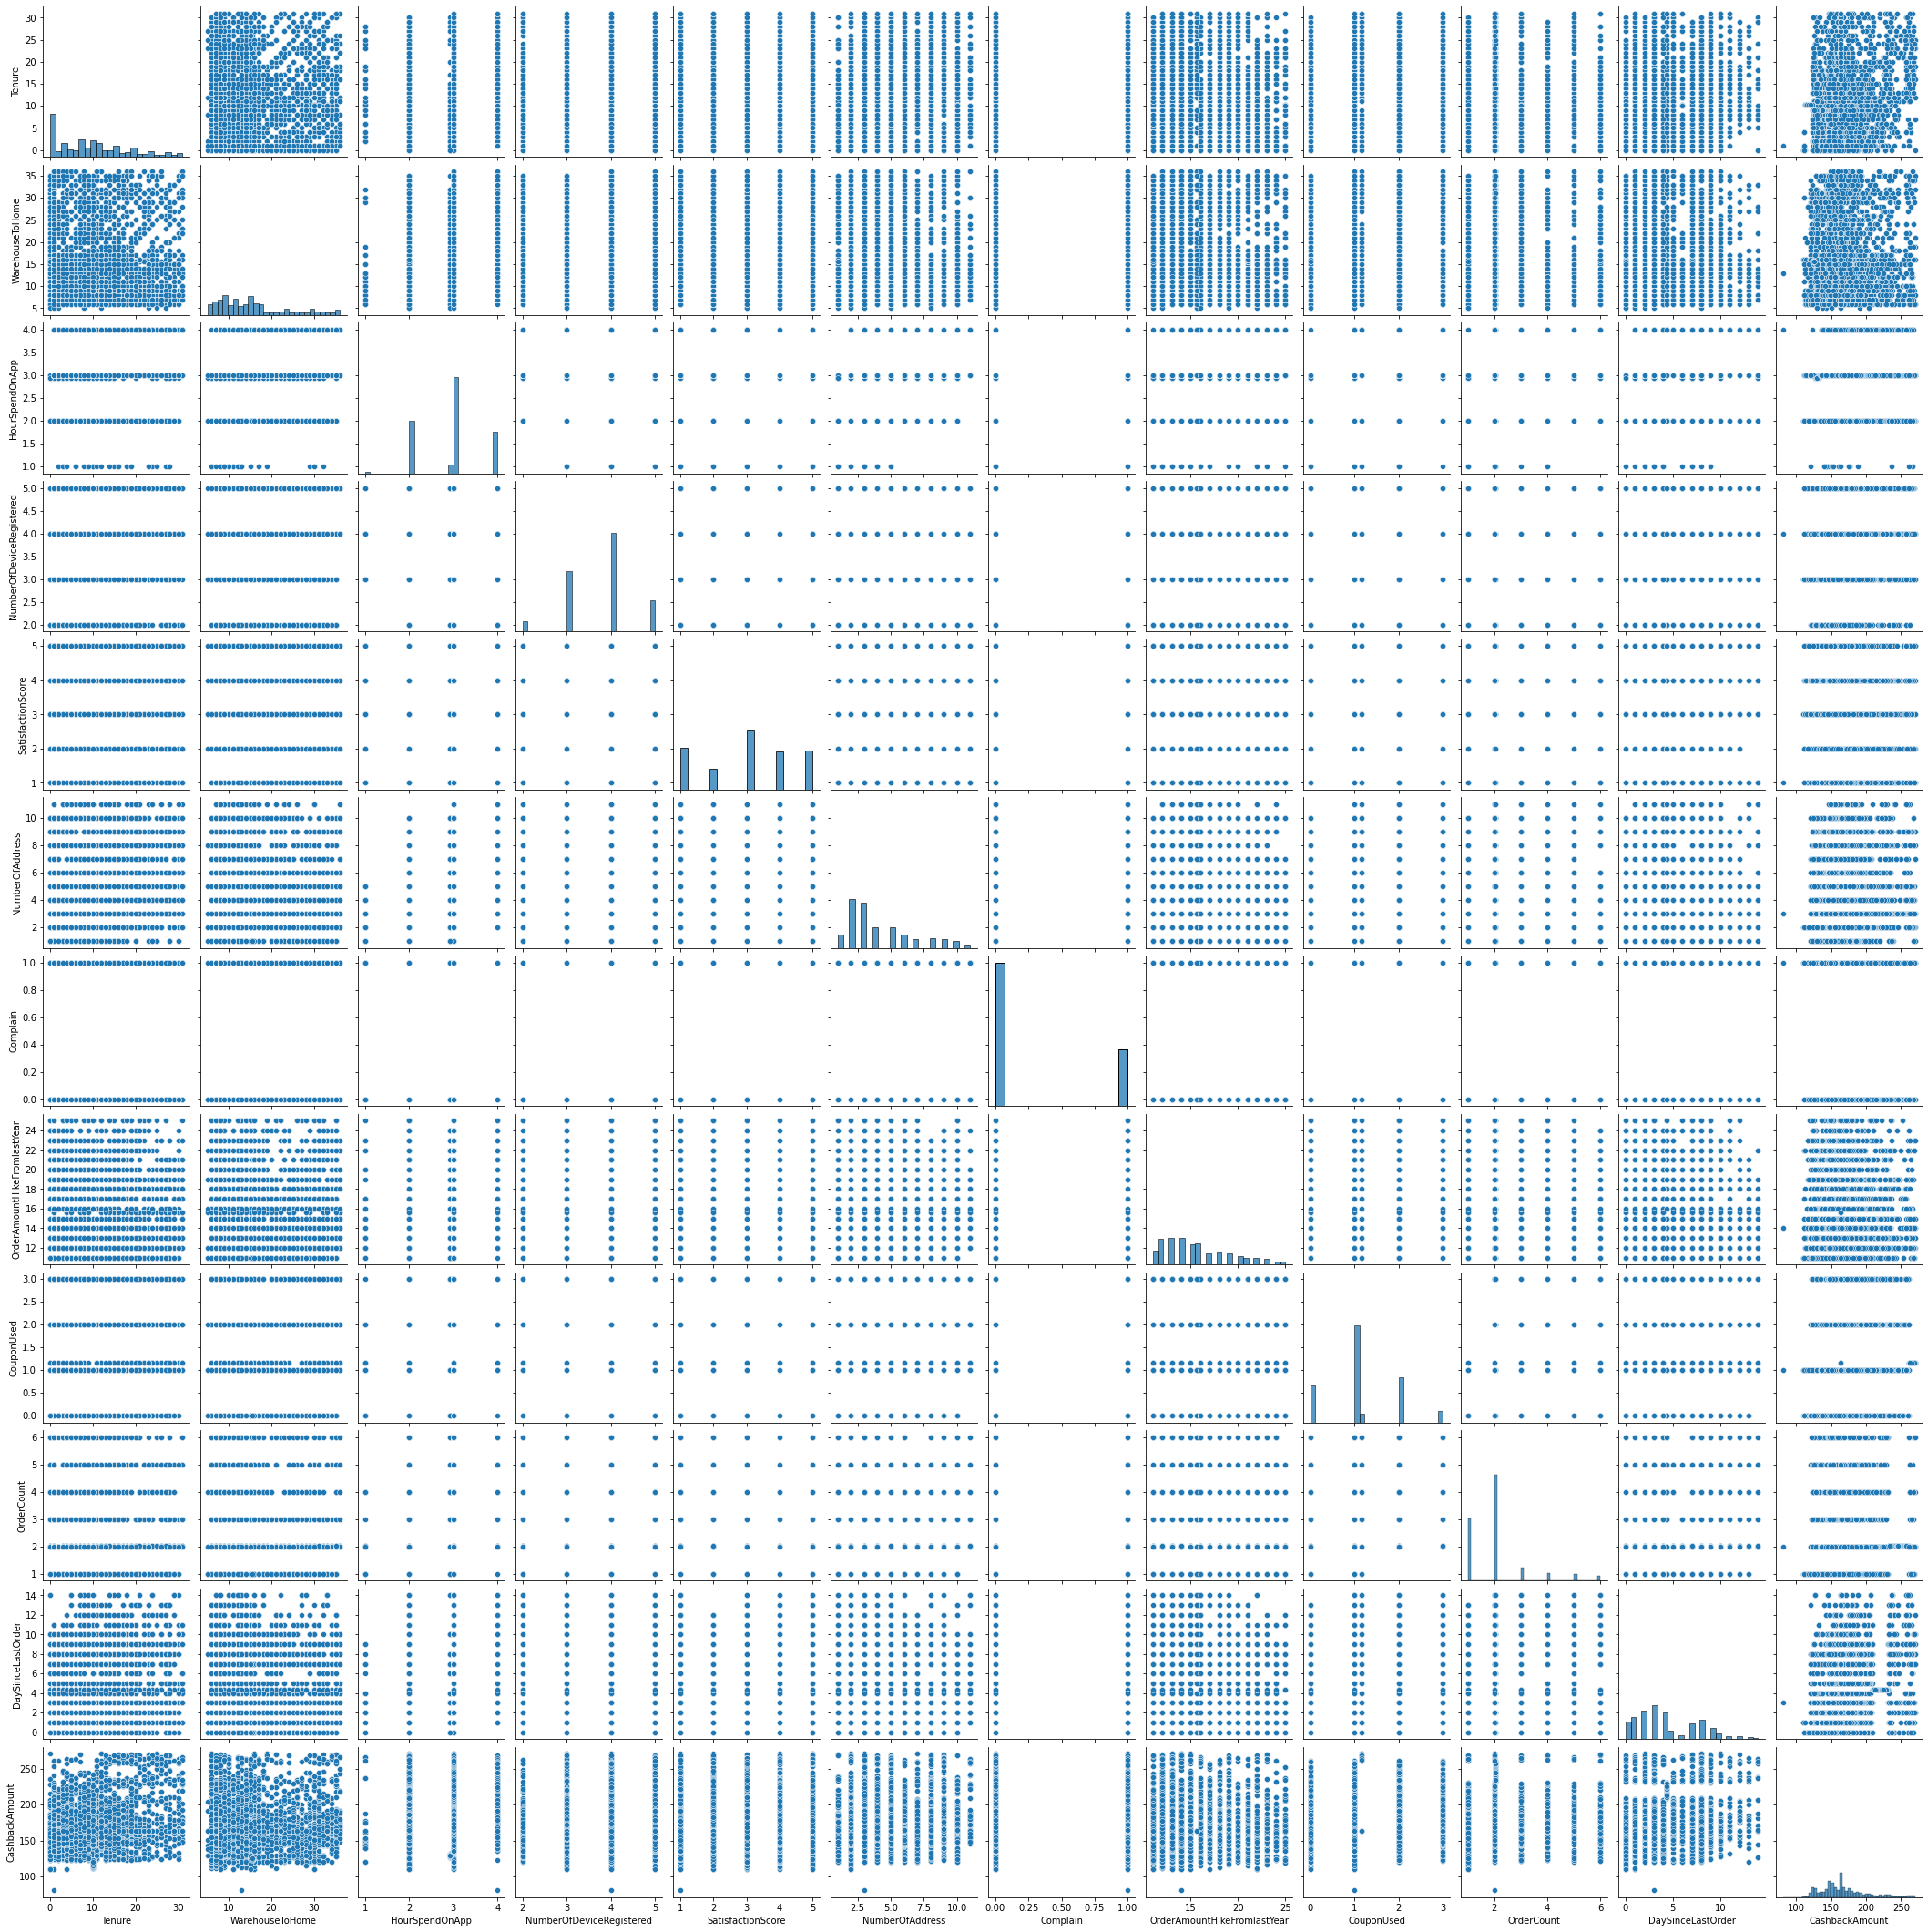

In [18]:
numerical_columns = df.select_dtypes(include=[np.number])

# Exclude two numerical columns (replace 'Column1' and 'Column2' with the actual column names)
columns_to_exclude = ['CustomerID', 'Churn']
numerical_columns = numerical_columns.drop(columns=columns_to_exclude, errors='ignore')

# Create a pairplot for the remaining numerical columns
sns.pairplot(numerical_columns)
plt.show()

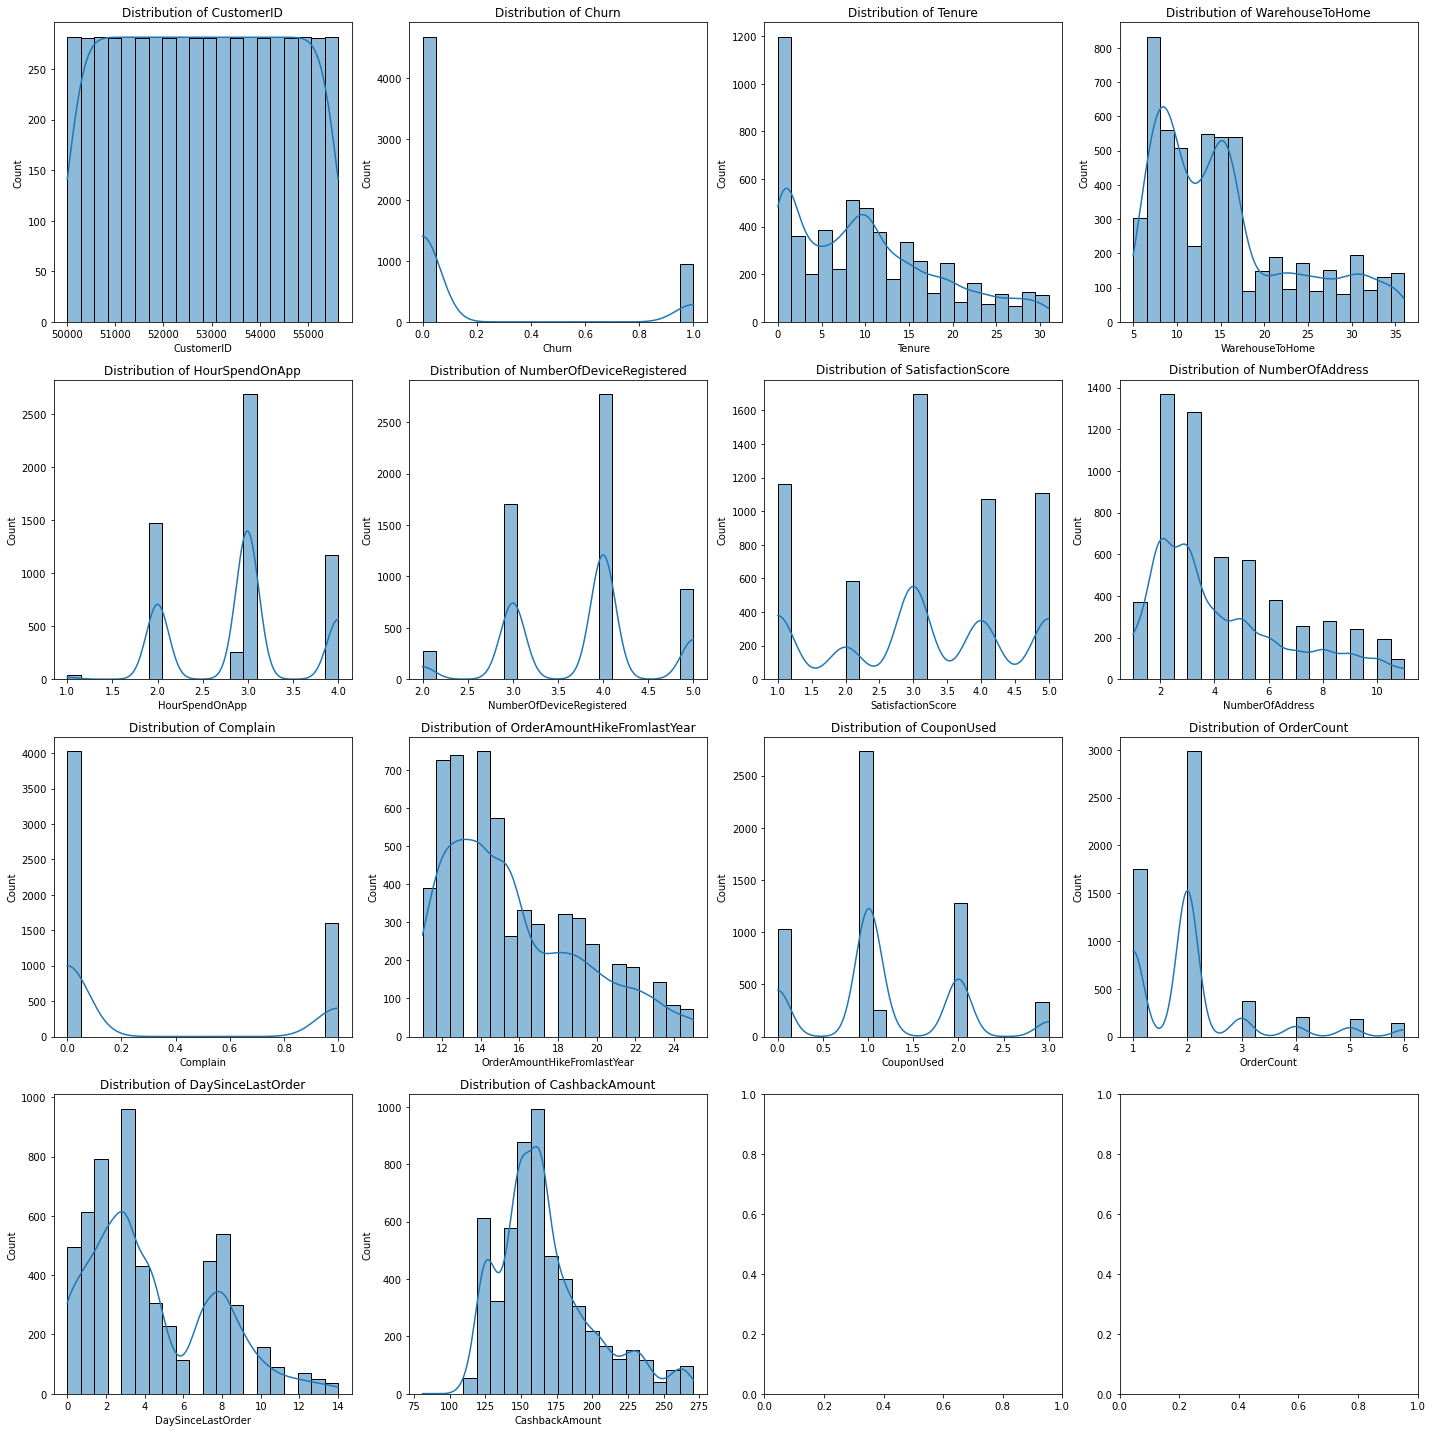

In [19]:
# Set up subplots for numerical variables
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()

# Plot distribution plots for numerical variables
for i, column in enumerate(df.select_dtypes(include=[int, float]).columns):
    sns.histplot(df[column], kde=True, label=column, bins=20, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [20]:
columns_to_transform = ['Tenure', 'WarehouseToHome', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'CashbackAmount']
data_to_transform = df[columns_to_transform]
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)
transformed_data = power_transformer.fit_transform(data_to_transform)
df[columns_to_transform] = transformed_data

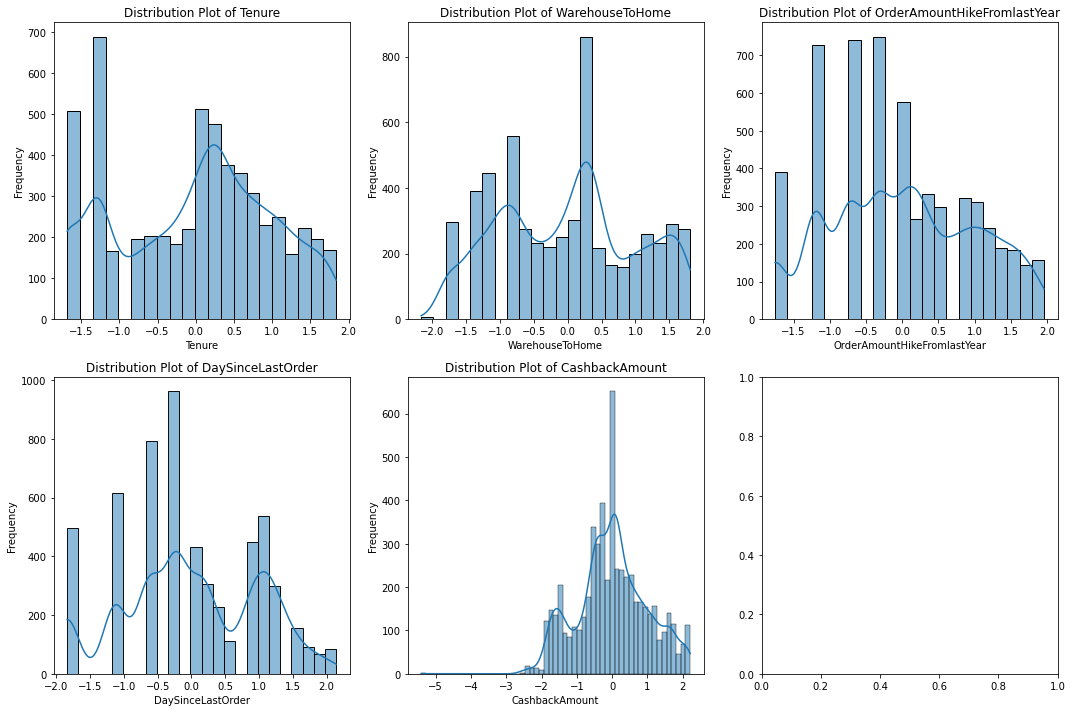

In [21]:
#Transforming the some of the numerical variables which are skewed
columns_to_plot = ['Tenure', 'WarehouseToHome', 'OrderAmountHikeFromlastYear', 'DaySinceLastOrder', 'CashbackAmount']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
# Create distribution plots for each selected column
for i, column in enumerate(columns_to_plot):
    sns.histplot(df[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution Plot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
# Drop unnecessary columns
df = df.drop(['CustomerID'],axis=1)
df.head()

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,1,-0.593789,Mobile Phone,3,-1.747463,Debit Card,Female,3.000000,3.0,Laptop & Accessory,2.0,Single,9.0,1.0,-1.754749,1.0,1.0,0.387568,-0.034839
1,1,0.253424,Phone,1,-1.100446,UPI,Male,3.000000,4.0,Mobile,3.0,Single,7.0,1.0,0.020731,0.0,1.0,-1.839117,-1.808465
2,1,0.253424,Phone,1,1.504158,Debit Card,Male,2.000000,4.0,Mobile,3.0,Single,6.0,1.0,-0.328121,0.0,1.0,-0.236280,-1.869172
3,1,-1.683000,Phone,3,0.222129,Debit Card,Male,2.000000,4.0,Laptop & Accessory,5.0,Single,8.0,0.0,1.708352,0.0,1.0,-0.236280,-1.102013
4,1,-1.683000,Phone,1,-0.231114,CC,Male,2.932093,3.0,Mobile,5.0,Single,3.0,0.0,-1.754749,1.0,1.0,-0.236280,-1.304274


In [23]:
Y= df['Churn']
X= df.loc[:, df.columns != 'Churn']

In [24]:
#Training and testing data
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y, train_size = 0.7, test_size = 0.3, 
                                                                    random_state = 42, stratify=Y)

In [25]:
print(X_train.shape)
print(Y_train.shape)

(3940, 18)
(3940,)


#### Model building with
1) Imbalanced Classes

2) Class balancing with SMOTE

In [26]:
!pip install imbalanced-learn

In [27]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from imblearn import over_sampling

In [28]:
# perfom cross validation on the X_train & y_train 
from sklearn.model_selection import StratifiedKFold
#perform cross validation
skf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3940 entries, 5387 to 2761
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Tenure                       3940 non-null   float64 
 1   PreferredLoginDevice         3940 non-null   object  
 2   CityTier                     3940 non-null   category
 3   WarehouseToHome              3940 non-null   float64 
 4   PreferredPaymentMode         3940 non-null   object  
 5   Gender                       3940 non-null   category
 6   HourSpendOnApp               3940 non-null   float64 
 7   NumberOfDeviceRegistered     3940 non-null   float64 
 8   PreferedOrderCat             3940 non-null   object  
 9   SatisfactionScore            3940 non-null   float64 
 10  MaritalStatus                3940 non-null   category
 11  NumberOfAddress              3940 non-null   float64 
 12  Complain                     3940 non-null   float64 
 13  

In [30]:
#One-hot encoding on categorical variables
X_train = pd.get_dummies(X_train, columns=['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender',
                                        'PreferedOrderCat', 'MaritalStatus'], drop_first=True)
X_train.head()

,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
5387,-0.423230,-0.842275,4.000000,4.0,3.0,3.0,0.0,0.020731,2.000000,2.0,...,0,0,1,0,0,0,1,0,1,0
3145,-0.128999,-1.398094,4.000000,3.0,3.0,6.0,0.0,1.236805,1.168776,2.0,...,0,0,0,1,0,0,0,0,1,0
349,-1.683000,1.445966,2.932093,2.0,2.0,2.0,1.0,-1.754749,0.000000,1.0,...,0,0,1,0,0,1,0,0,0,0
5202,0.975610,-0.231114,3.000000,5.0,3.0,5.0,0.0,0.020731,1.000000,2.0,...,0,0,1,0,0,0,1,0,0,1
4133,0.812523,-0.842275,3.000000,4.0,3.0,7.0,0.0,0.220507,2.000000,5.0,...,0,0,1,0,0,0,0,1,1,0


In [31]:
X_train.shape

(3940, 30)

In [32]:
#Logistic Regression with imbalanced dataset
print("Logistic Regression Classifier: --------------------------")
for c in [0.01, 0.1, 1]:
    print("C=",c, "Penalty= l2")
    cv_score_mean=0
    for train_index, test_index in skf.split(X_train, Y_train):
        print("Train:", train_index, "Test:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        logreg_classifier = linear_model.LogisticRegression(penalty='l2',C=c)
        logreg_classifier.fit(X_train_cv,Y_train_cv)

        Y_test_pred= logreg_classifier.predict_proba(X_test_cv)
        cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
        cv_score_mean=cv_score_mean+cv_score
    print("ROC-AUC Score=", cv_score_mean/3)

Logistic Regression Classifier: --------------------------
C= 0.01 Penalty= l2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8804999880529888
C= 0.1 Penalty= l2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8900263747647138
C= 1 Penalty= l2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.891202790154573


In [33]:
#KNN classifier with imbalanced dataset
print("KNN Classifier: --------------------------")
for n in [3, 5, 7, 9] :
    print("Neighbours =", n)
    cv_score_mean=0
    for train_index, test_index in skf.split(X_train, Y_train):
        print("Train:", train_index, "Test:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        knn_classifier= KNeighborsClassifier(n_neighbors = n ,n_jobs=-1)
        knn_classifier.fit(X_train_cv,Y_train_cv)

        Y_test_pred= knn_classifier.predict_proba(X_test_cv)
        cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
        cv_score_mean=cv_score_mean+cv_score
    print("ROC-AUC Score=", cv_score_mean/3)

KNN Classifier: --------------------------
Neighbours = 3
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8771199373567177
Neighbours = 5
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8789825754699923
Neighbours = 7
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8772684415866244
Neighbours = 9
Train: [1290 1291 1292 ... 393

In [34]:
#Decision Tree classifier with imbalanced dataset
print("Decision Trees Classifier: --------------------------")
for min_samples_split in [10, 5]:
    for min_samples_leaf in [10, 5]:
        for max_features in ['sqrt','log2',None]:
            print("min_samples_split=",min_samples_split, "min_samples_leaf=",min_samples_leaf,"max_features=",max_features)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
                
                dt_classifier= DecisionTreeClassifier(min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      max_features=max_features)
                dt_classifier.fit(X_train_cv,Y_train_cv)
                
                Y_test_pred= dt_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

Decision Trees Classifier: --------------------------
min_samples_split= 10 min_samples_leaf= 10 max_features= sqrt
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8564377010478902
min_samples_split= 10 min_samples_leaf= 10 max_features= log2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.8153861588666786
min_samples_split= 10 min_samples_leaf= 10 max_features= None
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0

In [37]:
#Random Forrest with imblanced dataset
for n_estimators in [100,150,200]:
    for min_samples_leaf in [10, 5]:
        for max_features in ['sqrt','log2',None]:
            print("number of estimators=",n_estimators, "min_samples_leaf=",min_samples_leaf,"max_features=",max_features)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
            
                rf_classifier= RandomForestClassifier(n_estimators=n_estimators,
                                                      min_samples_leaf=min_samples_leaf,
                                                      max_features=max_features, n_jobs=-1)
                rf_classifier.fit(X_train_cv,Y_train_cv)
            
                Y_test_pred= rf_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

number of estimators= 100 min_samples_leaf= 10 max_features= sqrt
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9249215004028648
number of estimators= 100 min_samples_leaf= 10 max_features= log2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9255496397252037
number of estimators= 100 min_samples_leaf= 10 max_features= None
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610

In [ ]:
#XG Boost classifier with imbalanced dataset
print("XGBOOST Classifier: --------------------------")
for n_est in [100, 150, 200]:
    for l_rate in [0.1, 0.2, 0.3]:
        for min_chd_weight in [1,3, 5]:
            print("number of estimators=",n_est, "learning rate=",l_rate,"minimum child weight=",min_chd_weight)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
                
                xgboost_classifier= XGBClassifier(n_estimators = n_est,
                                    learning_rate = l_rate, min_child_weight = min_chd_weight,
                                    subsample=0.6, n_jobs=-1)
                xgboost_classifier.fit(X_train_cv,Y_train_cv)
            
                Y_test_pred= xgboost_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

### Cross Validation ROC-AUC score on imbalanced dataset

#####  1) Logistic Regression (C = 1, Penelty = l2) = 0.8912

####   2) KNN Algorithm (n = 5) = 0.8789

####   3) Decision Tree (min_samples_split= 10, min_samples_leaf= 10, max_features= None) = 0.8896

####   4) Random Forrest (number of estimators= 200, min_samples_leaf= 5, max_features= sqrt) = 0.9395

####   5) XG Boost (number of estimators= 200 learning rate= 0.1 minimum child weight= 1)  = 0.9574

In [ ]:
#Class distribution after applying SMOTE
import warnings
warnings.filterwarnings("ignore")


sm = over_sampling.SMOTE(random_state=0)
X_train_smote, Y_train_smote = sm.fit_resample(X_train, Y_train)
# Artificial minority samples and corresponding minority labels from SMOTE are appended
# below X_train and y_train respectively
# So to exclusively get the artificial minority samples from SMOTE, we do
X_train_smote_1 = X_train_smote[X_train.shape[0]:]

X_train_1 = X_train.to_numpy()[np.where(Y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(Y_train==0.0)]

In [ ]:
print(X_train_1.shape)

In [ ]:
print(X_train_0.shape)

In [ ]:
print(X_train_smote.shape)

In [ ]:
#Logistic Regression with SMOTE
print("Logistic Regression Classifier: --------------------------")
for c in [0.01, 0.1, 1]:
    print("C=",c, "Penalty= l2")
    cv_score_mean=0
    for train_index, test_index in skf.split(X_train, Y_train):
        print("Train:", train_index, "Test:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
        X_smo_cv,Y_smo_cv = smo.fit_resample(X_train_cv,Y_train_cv)
        
        logreg_classifier = linear_model.LogisticRegression(penalty='l2',C=c)
        logreg_classifier.fit(X_smo_cv,Y_smo_cv)

        Y_test_pred= logreg_classifier.predict_proba(X_test_cv)
        cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
        cv_score_mean=cv_score_mean+cv_score
    print("ROC-AUC Score=", cv_score_mean/3)

In [ ]:
#KNN classifier with SMOTE
print("KNN Classifier: --------------------------")
for n in [3, 5, 7, 9] :
    print("Neighbours =", n)
    cv_score_mean=0
    for train_index, test_index in skf.split(X_train, Y_train):
        print("Train:", train_index, "Test:", test_index)
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
        X_smo_cv,Y_smo_cv = smo.fit_resample(X_train_cv,Y_train_cv)
        
        knn_classifier= KNeighborsClassifier(n_neighbors = n ,n_jobs=-1)
        knn_classifier.fit(X_smo_cv,Y_smo_cv)
        
        Y_test_pred= knn_classifier.predict_proba(X_test_cv)
        cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
        cv_score_mean=cv_score_mean+cv_score
    print("ROC-AUC Score=", cv_score_mean/3)

In [ ]:
#Decision Tree classifier with SMOTE
print("Decision Trees Classifier: --------------------------")
for min_samples_split in [10, 5]:
    for min_samples_leaf in [10, 5]:
        for max_features in ['sqrt','log2',None]:
            print("min_samples_split=",min_samples_split, "min_samples_leaf=",min_samples_leaf,"max_features=",max_features)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
                
                smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
                X_smo_cv,Y_smo_cv = smo.fit_resample(X_train_cv,Y_train_cv)
        
                dt_classifier= DecisionTreeClassifier(min_samples_split=min_samples_split,
                                                      min_samples_leaf=min_samples_leaf,
                                                      max_features=max_features)
                dt_classifier.fit(X_smo_cv,Y_smo_cv)
                
                Y_test_pred= dt_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

In [38]:
#Random Forrest with SMOTE
for n_estimators in [100,150,200]:
    for min_samples_leaf in [10, 5]:
        for max_features in ['sqrt','log2',None]:
            print("number of estimators=",n_estimators, "min_samples_leaf=",min_samples_leaf,"max_features=",max_features)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
                
                smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
                X_smo_cv,Y_smo_cv = smo.fit_resample(X_train_cv,Y_train_cv)
            
                rf_classifier= RandomForestClassifier(n_estimators=n_estimators,
                                                      min_samples_leaf=min_samples_leaf,
                                                      max_features=max_features, n_jobs=-1)
                rf_classifier.fit(X_smo_cv,Y_smo_cv)
            
                Y_test_pred= rf_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

number of estimators= 100 min_samples_leaf= 10 max_features= sqrt
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.922626638027606
number of estimators= 100 min_samples_leaf= 10 max_features= log2
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9189285477594876
number of estimators= 100 min_samples_leaf= 10 max_features= None
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 

In [43]:
#XG Boost classifier with SMOTE
print("XGBOOST Classifier: --------------------------")
for n_est in [100, 150, 200]:
    for l_rate in [0.1, 0.2, 0.3]:
        for min_chd_weight in [1,3, 5]:
            print("number of estimators=",n_est, "learning rate=",l_rate,"minimum child weight=",min_chd_weight)
            cv_score_mean=0
            for train_index, test_index in skf.split(X_train, Y_train):
                print("Train:", train_index, "Test:", test_index)
                X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
                Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
                
                smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
                X_smo_cv,Y_smo_cv = smo.fit_resample(X_train_cv,Y_train_cv)
            
                xgboost_classifier= XGBClassifier(n_estimators = n_est,
                                    learning_rate = l_rate, min_child_weight = min_chd_weight,
                                    subsample=0.6, n_jobs=-1)
                xgboost_classifier.fit(X_smo_cv,Y_smo_cv)
            
                Y_test_pred= xgboost_classifier.predict_proba(X_test_cv)
                cv_score= roc_auc_score(y_true=Y_test_cv,y_score=Y_test_pred[:,1])
                cv_score_mean=cv_score_mean+cv_score
            print("ROC-AUC Score=", cv_score_mean/3)

XGBOOST Classifier: --------------------------
number of estimators= 100 learning rate= 0.1 minimum child weight= 1
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9439231976366683
number of estimators= 100 learning rate= 0.1 minimum child weight= 3
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9392698822844587
number of estimators= 100 learning rate= 0.1 minimum child weight= 5
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690

ROC-AUC Score= 0.9514614128953425
number of estimators= 200 learning rate= 0.2 minimum child weight= 5
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.9426324149521542
number of estimators= 200 learning rate= 0.3 minimum child weight= 1
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0    1    2 ... 2685 2686 2690] Test: [2610 2611 2612 ... 3937 3938 3939]
ROC-AUC Score= 0.950553184780249
number of estimators= 200 learning rate= 0.3 minimum child weight= 3
Train: [1290 1291 1292 ... 3937 3938 3939] Test: [   0    1    2 ... 1396 1402 1407]
Train: [   0    1    2 ... 3937 3938 3939] Test: [1290 1291 1292 ... 2685 2686 2690]
Train: [   0

### Cross Validation ROC-AUC after applying SMOTE

#####  1) Logistic Regression (C = 0.01, Penelty = l2) = 0.8789

####   2) KNN Algorithm (n = 5) = 0.9044

####   3) Decision Tree (min_samples_split= 10 min_samples_leaf= 10 max_features= None) = 0.8790

####   4) Random Forrest (number of estimators= 200, min_samples_leaf= 5, max_features= None) = 0.9368

####   5) XG Boost (number of estimators= 200 learning rate= 0.2 minimum child weight= 1)  = 0.9531

#### Best Models on imbalanced dataset :

####  1) Random Forrest (number of estimators= 200, min_samples_leaf= 5, max_features= None) = 0.9395

####   2) XG Boost (number of estimators= 200, learning rate= 0.1, minimum child weight= 1)  = 0.9574

#### Best Models on after applying SMOTE :

####  1) Random Forrest (number of estimators= 200, min_samples_leaf= 5, max_features= None) = 0.9368

####   2) XG Boost (number of estimators= 200 learning rate= 0.2, minimum child weight= 1)  = 0.9531

##### Using the best model to predict on test dataset

In [40]:
#One-hot encoding on categorical data
X_test = pd.get_dummies(X_test, columns=['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender',
                                        'PreferedOrderCat', 'MaritalStatus'], drop_first=True)
X_test.head()

,Tenure,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,...,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
174,1.408625,-1.100446,2.0,5.0,4.0,6.0,0.0,0.832757,0.0,1.0,...,0,0,1,0,1,0,0,0,1,0
5498,-1.293469,0.349633,3.0,4.0,1.0,3.0,0.0,-0.328121,1.0,2.0,...,0,0,1,0,0,0,1,0,0,1
4705,-0.593789,1.715008,4.0,4.0,1.0,9.0,0.0,1.838646,3.0,2.0,...,1,0,1,0,1,0,0,0,1,0
1154,-0.128999,0.299565,2.0,3.0,4.0,2.0,1.0,-1.200464,1.0,2.0,...,0,0,1,0,0,1,0,0,1,0
4850,-0.423230,0.681088,3.0,4.0,1.0,2.0,1.0,-1.200464,1.0,2.0,...,0,0,0,0,1,0,0,0,1,0


In [41]:
#Random Forrest without oversampling
clf = RandomForestClassifier(min_samples_split= 5, min_samples_leaf=5, max_features=None)  
clf.fit(X_train_cv, Y_train_cv)
#predict on test to give probability
Y_pred= clf.predict_proba(X_test)

#calculate the ROC-AUC
score= roc_auc_score(y_true=Y_test,y_score=Y_pred[:,1])
print("Random Forrest without oversampling ROC-AUC Score =", score)

Random Forrest without oversampling ROC-AUC Score = 0.9348902883990602


In [42]:
#XG Boost without oversampling
clf = XGBClassifier(n_estimators=200,learning_rate=0.1,subsample=0.6, n_jobs=-1, min_child_weight = 1) 
clf.fit(X_train_cv, Y_train_cv)
Y_pred= clf.predict_proba(X_test)
score= roc_auc_score(y_true=Y_test,y_score=Y_pred[:,1])
print("XGBOOST Classifier without oversampling ROC-AUC Score =", score)

XGBOOST Classifier without oversampling ROC-AUC Score = 0.9571649922527116


In [45]:
#Random Forrest with SMOTE
clf = RandomForestClassifier(n_estimators=200, min_samples_leaf=10, max_features=None)  
smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
X_smo,Y_smo = smo.fit_resample(X_train,Y_train) 
clf.fit(X_smo,Y_smo)
Y_pred= clf.predict_proba(X_test)
score= roc_auc_score(y_true=Y_test,y_score=Y_pred[:,1])
print("Random Forest Classifier ROC-AUC Score =", score)

Random Forest Classifier ROC-AUC Score = 0.9248213125406108


In [47]:
#XG Boost with SMOTE
clf = XGBClassifier(n_estimators=200,learning_rate=0.2,subsample=0.6, n_jobs=-1, min_child_weight = 1) 
smo = over_sampling.SMOTE(sampling_strategy='minority', random_state=42)
X_smo,Y_smo = ros.fit_resample(X_train,Y_train) 
clf.fit(X_smo,Y_smo)
Y_pred= clf.predict_proba(X_test)
score= roc_auc_score(y_true=Y_test,y_score=Y_pred[:,1])
print("XGBOOST Classifier ROC-AUC Score =", score)

XGBOOST Classifier ROC-AUC Score = 0.972847003548758


#### XG Boost with SMOTE is the best model

In [48]:
#Print the important features of the best model to understand the dataset
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

Top var = 1
2nd Top var = 7
3rd Top var = 24


In [50]:
# To choose the best threshold
y_train_pred= clf.predict_proba(X_train.values)
y_df = pd.DataFrame({'actual_label':Y_train, 'predicted_prob':y_train_pred[:,1]})
y_df['predicted_prob'] = y_df['predicted_prob'].apply(lambda x: '{:.6f}'.format(x))
y_df.head()

,actual_label,predicted_prob
5387,0,0.000031
3145,0,0.000876
349,0,0.110635
5202,0,0.001178
4133,0,0.000555


In [52]:
# find the best threshold on roc_curve to know the range for search
fpr, tpr, thresholds = metrics.roc_curve(Y_train, y_train_pred[:,1])
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

0.7509497


In [53]:
# Let's create columns with different probability cutoffs 
thresholds = [0.72,0.73,0.74,0.75,0.76,0.77,0.78]
for i in thresholds:
    y_df[i]= y_df.predicted_prob.map(lambda x: 1 if float(x) > i else 0)
y_df.head()

,actual_label,predicted_prob,0.72,0.73,0.74,0.75,0.76,0.77,0.78
5387,0,0.000031,0,0,0,0,0,0,0
3145,0,0.000876,0,0,0,0,0,0,0
349,0,0.110635,0,0,0,0,0,0,0
5202,0,0.001178,0,0,0,0,0,0,0
4133,0,0.000555,0,0,0,0,0,0,0


In [64]:
# calculate Precision and Recall  for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob', 'accuracy', 'precision','recall'])
from sklearn.metrics import confusion_matrix

thresholds = [0.72,0.73,0.74,0.75,0.76,0.77,0.78]
for i in thresholds:
    cm = metrics.confusion_matrix(y_df.actual_label, y_df[i])
    accuracy = (cm[1, 1] + cm[0, 0]) / sum(sum(cm))
    precision = cm[1,1]/(cm[1,1]+cm[0,1])
    recall =  cm[1,1]/(cm[1,1]+cm[1,0])

    cutoff_df.loc[i] = [i, accuracy, precision, recall]
print(cutoff_df)

      prob  accuracy  precision    recall
0.72  0.72  1.000000        1.0  1.000000
0.73  0.73  1.000000        1.0  1.000000
0.74  0.74  1.000000        1.0  1.000000
0.75  0.75  1.000000        1.0  1.000000
0.76  0.76  0.999746        1.0  0.998492
0.77  0.77  0.999746        1.0  0.998492
0.78  0.78  0.999746        1.0  0.998492


In [66]:
y_test_pred= clf.predict_proba(X_test.values)
y_df = pd.DataFrame({'actual_label':Y_test, 'predicted_prob':y_test_pred[:,1]})
y_df['predicted_prob'] = y_df['predicted_prob'].apply(lambda x: '{:.6f}'.format(x))
y_df['predicted_label']= y_df.predicted_prob.map(lambda x: 1 if float(x) > 0.75 else 0)
y_df.head()

,actual_label,predicted_prob,predicted_label
174,0,0.000056,0
5498,1,0.006597,0
4705,0,0.001117,0
1154,1,0.376178,0
4850,0,0.018358,0


In [67]:
cm = metrics.confusion_matrix(y_df.actual_label, y_df.predicted_label)
precision = cm[1,1]/(cm[1,1]+cm[0,1])
recall =  cm[1,1]/(cm[1,1]+cm[1,0])
accuracy = (cm[1, 1] + cm[0, 0]) / sum(sum(cm))

print("Precision:",precision)
print("Recall:",recall)
print("Accuracy:",accuracy)

Precision: 0.9427312775330396
Recall: 0.7508771929824561
Accuracy: 0.9502664298401421


##### We will use 0.75 as threshold as high accuracy is good in predicting whether a customer will churn or not